<a href="https://colab.research.google.com/github/RawaaBOUALI/Facial_Emotion_Recognition_CNN/blob/main/CNN_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Recognition using CNN**

## Abstract

This is an academic project which aims to develop an FER system in order to reveal some hints about sentiments.


## Realisation

### Download Data from kaggle 

In [1]:
import os

# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip data
!unzip *.zip 

kaggle.json
/content/data
100% 284M/285M [00:15<00:00, 17.8MB/s]
100% 285M/285M [00:15<00:00, 19.6MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


### Load Data


Load the "train.csv" file, and convert it to numpy array. 
The training images and labels are saved in "x_train" and "y_train" respectively.

In [2]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


The dataset contains 7 different facial expression categories:

*   0=Angry
*   1=Disgust
*   2=Fear
*   3=Happy
*   4=Sad
*   5=Surprise
*   6=Neutral

The the histogram below shows the distribution of the 7 facial expression categories:

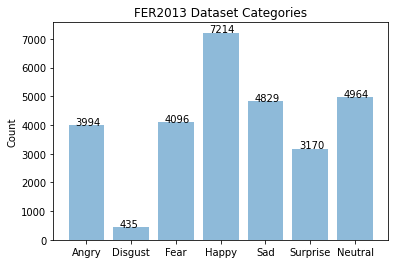

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)
    plt.text(label - 0.25, count + 15, str(count))

plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

Label is: 3


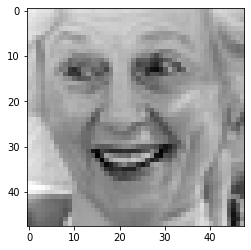

In [6]:
image = x_train[25]
label = y_train[25]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

### Preprocess Data

Split the dataset into training set and test set. ( 20% as testing set, and the rest as training set).

In [7]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


### Train the Model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Activation

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Inspired by the VGGNet architecture we designed a model that is composed of 5 stacks of layers. 

In each of the first 4 stacks of layers, there are 2 convolutional layer followed by 1 pooling layer. Besides, we used batch normalization to speed up training and dropout to prevent over-fitting.

Then one stack of 3 fully-connected layers, followed by a Softmax activation function, which generates the probability of the 7 facial expression categories. 

Finally, we compiled our model using Adam optimizer with a certain learning rate. 

Considering that we are dealing with classification issue, we used sparse_categorical_crossentropy as the loss function.

In [10]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                      

Train the model using Early Stopping strategy, which will stop the training process when there is no improvement in the validation accuracy. 

In [11]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

cnn_model.save('emotion_detection_model.h5')

Epoch 1/100
359/359 [==============================] - 28s 51ms/step - loss: 1.8797 - accuracy: 0.2300 - val_loss: 2.0243 - val_accuracy: 0.2569 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 16s 44ms/step - loss: 1.6735 - accuracy: 0.3263 - val_loss: 1.5508 - val_accuracy: 0.3851 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 16s 45ms/step - loss: 1.5111 - accuracy: 0.4093 - val_loss: 1.6076 - val_accuracy: 0.3884 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 16s 45ms/step - loss: 1.3895 - accuracy: 0.4708 - val_loss: 1.4016 - val_accuracy: 0.4347 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 16s 44ms/step - loss: 1.3140 - accuracy: 0.5032 - val_loss: 1.4296 - val_accuracy: 0.4497 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 16s 44ms/step - loss: 1.2735 - accuracy: 0.5209 - val_loss: 1.3037 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

After the training process is completed, here is the accuracy diagram of the training and validation accuracy.

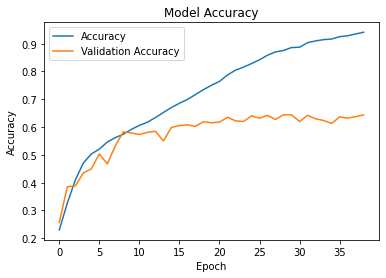

In [12]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

### Improving the Model

Trying to improve the model in order to increase the validation accuracy by:


*   Generate hard data
*   Data augmentation


The score before improvement is around 64%.

In [13]:
# Evaluate the model before improvement
_, score_before_improvement = cnn_model.evaluate(x_test, y_test)
print('Score before improvement: {}'.format(score_before_improvement))

180/180 [==============================] - 2s 10ms/step - loss: 1.8652 - accuracy: 0.6439
Score before improvement: 0.6438522934913635


Trying to improve the model by generating hard data. Instead of training the model over and over again, select the images which are incorrectly labelled by the model, and train the model on these specific images. 

In [14]:
hard_images = []
hard_labels = []

# Make predictions
predictions = cnn_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

180/180 [==============================] - 1s 7ms/step
(4718, 48, 48, 1)
(4718,)


In [15]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = cnn_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
59/59 [==============================] - 4s 71ms/step - loss: 0.1699 - accuracy: 0.9446 - val_loss: 0.0554 - val_accuracy: 0.9831 - lr: 5.9049e-04
Epoch 2/100
59/59 [==============================] - 3s 46ms/step - loss: 0.1261 - accuracy: 0.9581 - val_loss: 0.0693 - val_accuracy: 0.9809 - lr: 5.9049e-04
Epoch 3/100
59/59 [==============================] - 3s 46ms/step - loss: 0.1155 - accuracy: 0.9637 - val_loss: 0.0530 - val_accuracy: 0.9841 - lr: 5.9049e-04
Epoch 4/100
59/59 [==============================] - 3s 46ms/step - loss: 0.1020 - accuracy: 0.9658 - val_loss: 0.0591 - val_accuracy: 0.9756 - lr: 5.9049e-04
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 0.1055 - accuracy: 0.9669 - val_loss: 0.1649 - val_accuracy: 0.9449 - lr: 5.9049e-04
Epoch 6/100
59/59 [==============================] - 3s 44ms/step - loss: 0.0727 - accuracy: 0.9730 - val_loss: 0.0981 - val_accuracy: 0.9682 - lr: 5.9049e-04
Epoch 7/100
59/59 [===========================

This might cause the over-fitting issue on these incorrectly labelled images. Therefore, we will train the model again to balance out. 

Besides, we will also perform data augmentation to diversify our training dataset by rotating, shifting, zooming or flipping the images, which will also improve our model to overcome the over-fitting issue and learn the generic features of each image.

In [16]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train, 
                           y_train, 
                           batch_size=64)

# Train the model again to balance out
history = cnn_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 18s 47ms/step - loss: 1.1012 - accuracy: 0.6282 - val_loss: 1.0017 - val_accuracy: 0.6398 - lr: 4.7830e-04
Epoch 2/100
359/359 [==============================] - 16s 46ms/step - loss: 0.9980 - accuracy: 0.6505 - val_loss: 0.9793 - val_accuracy: 0.6498 - lr: 4.7830e-04
Epoch 3/100
359/359 [==============================] - 16s 45ms/step - loss: 0.9629 - accuracy: 0.6603 - val_loss: 0.9622 - val_accuracy: 0.6566 - lr: 4.7830e-04
Epoch 4/100
359/359 [==============================] - 17s 48ms/step - loss: 0.9418 - accuracy: 0.6687 - val_loss: 0.9665 - val_accuracy: 0.6534 - lr: 4.7830e-04
Epoch 5/100
359/359 [==============================] - 16s 45ms/step - loss: 0.9307 - accuracy: 0.6720 - val_loss: 0.9755 - val_accuracy: 0.6513 - lr: 4.7830e-04
Epoch 6/100
359/359 [==============================] - 16s 45ms/step - loss: 0.9256 - accuracy: 0.6724 - val_loss: 0.9257 - val_accuracy: 0.6632 - lr: 4.7830e-04
Epoch 7/100
359/359 [=======

Evaluation of the model again after improvement. 

Previously, the validation accuracy was around 64%. Nevertheless, the validation accuracy has increased to around 68%.

In [ ]:
# Evaluate the model after improvement
_, score_after_improvement = cnn_model.evaluate(x_test, y_test)
print('Score after improvement: {}'.format(score_after_improvement))

180/180 [==============================] - 1s 8ms/step - loss: 0.9613 - accuracy: 0.6848
Score after improvement: 0.6847788095474243


### Evaluate the Model

Make predictions and create the confusion matrix.
Since FER2013 dataset does not provide too many images labelled with "Disgust", we can tell from the confusion matrix that, the model might not be able to classify the images labelled with "Disgust" very well.

180/180 [==============================] - 1s 7ms/step


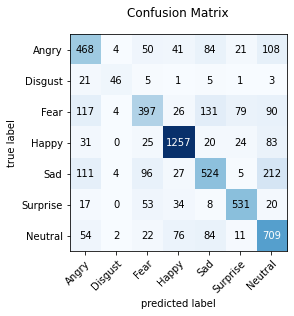

In [ ]:
!pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = cnn_model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

Prediction

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = numpy.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = numpy.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = cnn_model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

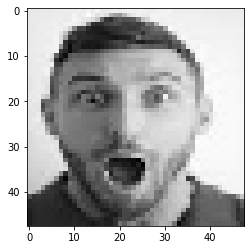

1/1 [==============================] - 0s 16ms/step


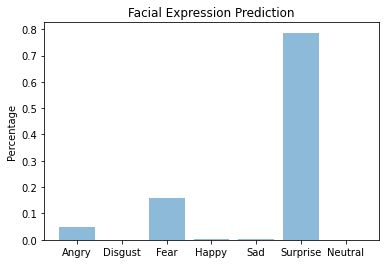

In [ ]:
# Surprise
predict_facial_expression('sup.jfif')

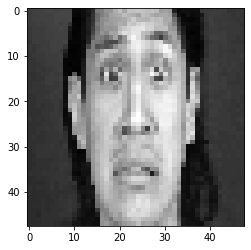

1/1 [==============================] - 0s 26ms/step


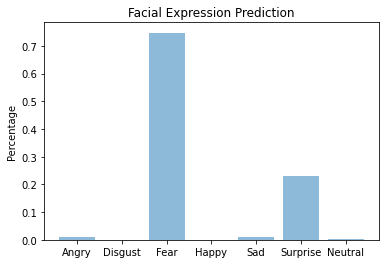

In [ ]:
# Fear
predict_facial_expression('fear.jpg')

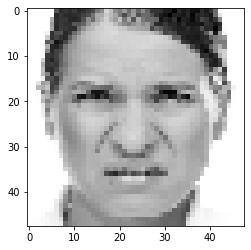

1/1 [==============================] - 0s 17ms/step


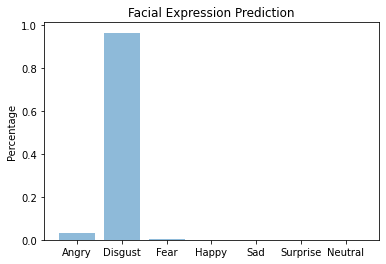

In [ ]:
# Disgust
predict_facial_expression('ew.jpg')

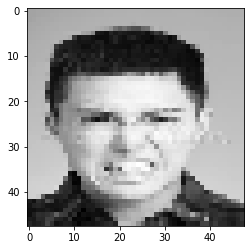

1/1 [==============================] - 0s 19ms/step


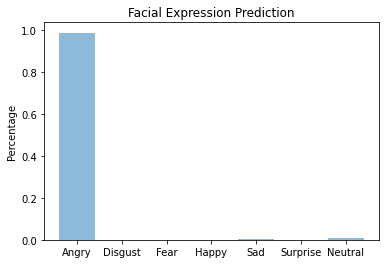

In [ ]:
# Angry
predict_facial_expression('ang.jpg')

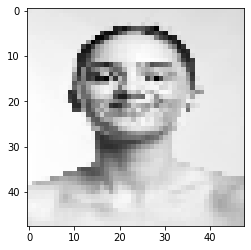

1/1 [==============================] - 0s 16ms/step


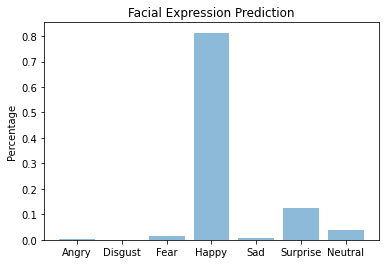

In [ ]:
# Happy
predict_facial_expression('hg.jpg')

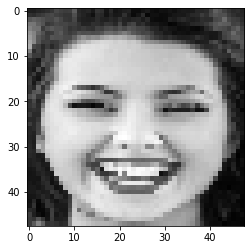

1/1 [==============================] - 0s 19ms/step


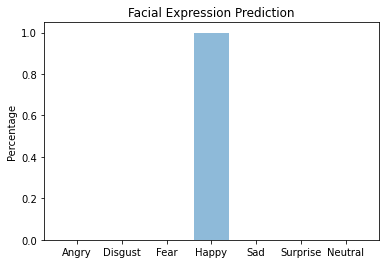

In [ ]:
# Happy
predict_facial_expression('hap1.jpg')

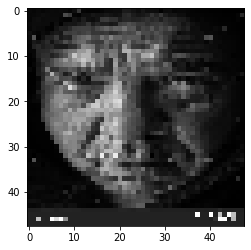

1/1 [==============================] - 0s 16ms/step


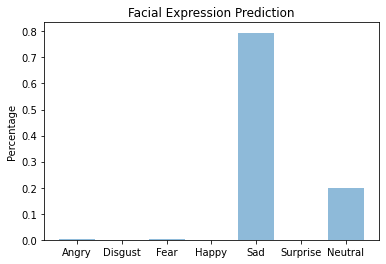

In [ ]:
# Sad
predict_facial_expression('1.jpg')